# Initial Model

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import arviz as az

from cmdstanpy import cmdstan_path, CmdStanModel

In [37]:
%run utils.py

In [2]:
PROJECT_DIR = "/home/george/parts/"
print(cmdstan_path())

/home/george/.cmdstanpy/cmdstan-2.21.0


## Data

In [3]:
df = pd.read_csv(os.path.join(PROJECT_DIR, "data", "tidy", "parts.csv"))

In [4]:
class_name = "analysis.ii"

friday_mask = (df.loc[:, "class"] == "analysis.ii") & (df.loc[:, "day"] == "fri")
friday_data = df[friday_mask].loc[:, "parts"].dropna().values
non_friday_data = df[~friday_mask].loc[:, "parts"].dropna().values
N = non_friday_data.size
M = friday_data.size

In [5]:
def run_stan_model(stan_file, data, **kwargs):
    """
    Convenience function to compile, sample and diagnose a Stan model.
    
    Notes
    -----
    For prior predictive sampling (or to otherwise simulate data), pass `fixed_param=True`.
        https://cmdstanpy.readthedocs.io/en/latest/sample.html#example-generate-data-fixed-param-true
    """
    model = CmdStanModel(stan_file=stan_file)
    model.compile()
    fit = model.sample(data=data, **kwargs)
    fit.diagnose()
    return model, fit

## Examine Prior Predictive Distribution

In [6]:
data = {
    "N": 100  # Number of samples
}

model, fit = run_stan_model(
    stan_file=os.path.join(PROJECT_DIR, "models", "_00-initial-prior_pred.stan"),
    data=data,
    fixed_param=True,
)

"""
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    prior_predictive=["prior_pred_non_friday_parts", "prior_pred_friday_parts"],
    coords={'sample': np.arange(data["N"])},
    dims={
        "prior_pred_non_friday_parts": ["sample"],
        "prior_pred_friday_parts": ["sample"]
    }
)
""";

INFO:cmdstanpy:stan to c++ (/home/george/parts/models/_00-initial-prior_pred.hpp)
INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /home/george/parts/models/_00-initial-prior_pred
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


We need to use a Betancourt plot, since plotting the density will confuse the _distribution_ of parts (which is what we care about) with the _predicted number_ of parts (which is what `az.plot_density` would show).

In [7]:
prior_pred_non_friday_parts = fit.get_drawset(["prior_pred_non_friday_parts"])
prior_pred_friday_parts = fit.get_drawset(["prior_pred_friday_parts"])

In [41]:
bins = np.arange(50)
non_friday_hist = np.vstack([np.histogram(row, bins=bins)[0] for row in prior_pred_non_friday_parts.values])
friday_hist = np.vstack([np.histogram(row, bins=bins)[0] for row in prior_pred_friday_parts.values])

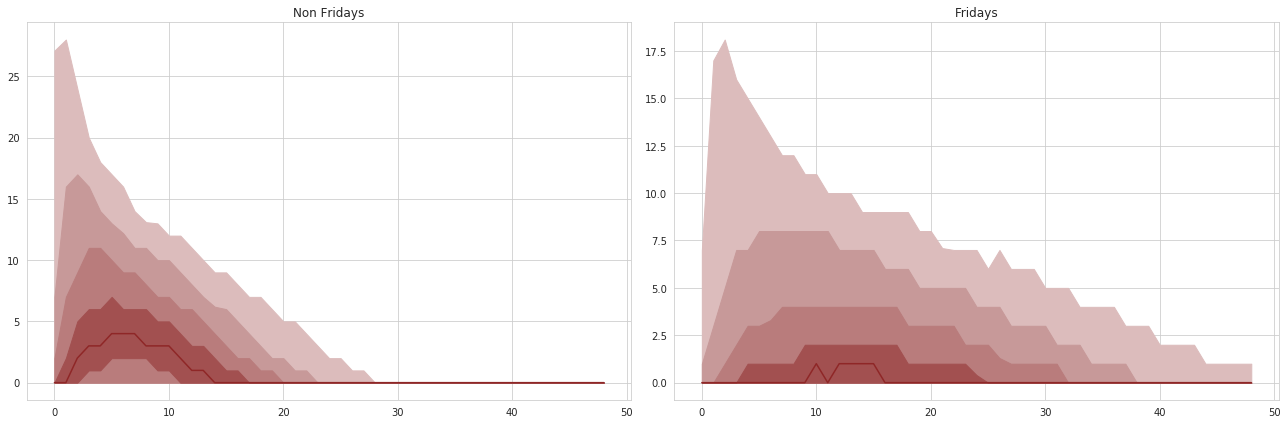

In [46]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=[18, 6])
plot_percentiles(non_friday_hist, title="Non Fridays", ax=axarr[0])
plot_percentiles(friday_hist, title="Fridays", ax=axarr[1])
plt.tight_layout()

## Fit Model